In [50]:
print ("hello world")

hello world


In [1]:
# %load ../train_and_append_boosted.py
import statistics
import collections
import getopt, sys
import matplotlib.pyplot as plt
import numpy as np
from numpy import linspace
import pandas
import math
from sklearn.preprocessing import StandardScaler
import root_numpy
from ROOT import gSystem
from root_numpy import root2array, array2tree
import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import plot_model
from math import sqrt
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import ROOT

Welcome to JupyROOT 6.14/04


Using TensorFlow backend.


In [2]:
class MyDict(collections.OrderedDict):
    def __missing__(self, key):
        val = self[key] = MyDict()
        return val


In [3]:
# This converts a flat ntuple into a numpy array file, which is the input
# format used by keras in our setup. Creates one .npz file per analysis in the
# directory where you run it.

# Location of the lists of ntuples you want to convert to numpy format.
# I've assumed that the file lists are named following my convention.
# e.g. "signalFiles_resolved.txt"
fileListLocation = "../datasets_to_train/"
appendListLocation = "../datasets_to_append/"

# Name of the tree we want to use
inTreeName = "preselection"

# Prefix for the name of the output .npz files
outputPrefix = "trainingData_all_jets_"
#outputPrefix = "validationData_"

#for analysis in ["resolved", "intermediate", "boosted"]:
for analysis in ["intermediate"]:
    inFile_sig   = fileListLocation + "/signalFiles_" + analysis + ".txt"
    inFile_4b    = fileListLocation + "/4bFiles_" + analysis + ".txt"
    inFile_2b2j  = fileListLocation + "/2b2jFiles_" + analysis + ".txt"
    inFile_ttbar = fileListLocation + "/ttbarFiles_" + analysis + ".txt"
    appendFile_sig   = appendListLocation + "/signalFiles_" + analysis + ".txt"
    appendFile_4b    = appendListLocation + "/4bFiles_" + analysis + ".txt"
    appendFile_2b2j  = appendListLocation + "/2b2jFiles_" + analysis + ".txt"
    appendFile_ttbar = appendListLocation + "/ttbarFiles_" + analysis + ".txt"

    branchList = ["pT_hh",
                  "nMuon", "nElec",
                  "h1_M", "h1_Pt", "h1_Eta", "h1_Phi", "h1_j1_j2_dR",
                  "h2_M", "h2_Pt", "h2_Eta", "h2_Phi", "h2_j1_j2_dR",
                  "met_Et", "met_Phi", 
                  "h1_j1_BTag","h1_j2_BTag","h2_j1_BTag","h2_j2_BTag",
                  "mc_sf"]
   #branchList = ["pT_hh", "dPhi_hh",
   #          "h1_M", "h1_Pt", "h1_Eta", "h1_j1_j2_dR",
   #          "h2_M", "h2_Pt", "h2_Eta", "h2_j1_j2_dR",
   #          "mc_sf"]

    nFeatures = len(branchList)-1

    filepaths_sig   = []
    filepaths_4b    = []
    filepaths_2b2j  = []
    filepaths_ttbar = []

    f = open(inFile_sig,"r")
    for line in f:
        filepaths_sig.append(line.rstrip())
    f.close()

    f = open(inFile_4b,"r")
    for line in f:
        filepaths_4b.append(line.rstrip())
    f.close()

    f = open(inFile_2b2j,"r")
    for line in f:
        filepaths_2b2j.append(line.rstrip())
    f.close()

    f = open(inFile_ttbar,"r")
    for line in f:
        filepaths_ttbar.append(line.rstrip())
    f.close()

    appendPaths_sig   = []
    appendPaths_4b    = []
    appendPaths_2b2j  = []
    appendPaths_ttbar = []

    f = open(appendFile_sig,"r")
    for line in f:
        appendPaths_sig.append(line.rstrip())
    f.close()

    f = open(appendFile_4b,"r")
    for line in f:
        appendPaths_4b.append(line.rstrip())
    f.close()

    f = open(appendFile_2b2j,"r")
    for line in f:
        appendPaths_2b2j.append(line.rstrip())
    f.close()

    f = open(appendFile_ttbar,"r")
    for line in f:
        appendPaths_ttbar.append(line.rstrip())
    f.close()

    dat_sig   = root2array(filepaths_sig,   branches=branchList, treename=inTreeName)
    dat_4b    = root2array(filepaths_4b,    branches=branchList, treename=inTreeName)
    dat_2b2j  = root2array(filepaths_2b2j,  branches=branchList, treename=inTreeName)
    dat_ttbar = root2array(filepaths_ttbar, branches=branchList, treename=inTreeName)
    datAppend_sig   = root2array(appendPaths_sig,   branches=branchList, treename=inTreeName)
    datAppend_4b    = root2array(appendPaths_4b,    branches=branchList, treename=inTreeName)
    datAppend_2b2j  = root2array(appendPaths_2b2j,  branches=branchList, treename=inTreeName)
    datAppend_ttbar = root2array(appendPaths_ttbar, branches=branchList, treename=inTreeName)

    #np.savez(outputPrefix + analysis + ".npz", sig=dat_sig, bkg_4b=dat_4b, bkg_2b2j=dat_2b2j, bkg_ttbar=dat_ttbar)


In [4]:
    nFeatures = len(branchList)-1


In [5]:
# This program trains a neural network based on input numpy array files.
# Output is one trained NN file (nn_*.h5) and one scaler file (scaler_*.sav)
# per analysis. Optionally also makes plots of the output distributions for the
# training sample.

### NOTE this program uses 0.2 of the data as a validation set

In [6]:
# Path of the directory whit lits of ntuples to append score to
# Path of the directory containing .npz files to train on.
# Standard naming convention is assumed (e.g. "trainingData_resolved.npz")
#trainingDataPath = "../train_all_jets/"

In [7]:
# Training parameters
numEpochs = 5
batchSize = 100
dropoutFraction = 0.3
# initial learning rate for adamax
init_lr = MyDict()
init_lr["boosted"] = 5e-5
init_lr["intermediate"] = 5e-2
init_lr["resolved"] = 5e-3

# store parameters of the network in a string
#param_string = "_w_OPadamaxEP"+str(numEpochs)+"BS"+str(batchSize)+"DO"+str(dropoutFraction).replace(".","")
# Plot score distributions for the training sample?
makePlots = False

target_nevents = 100000

signal_weight = MyDict()
ttbar_weight = MyDict()
bkg_weight = MyDict()
analysis = "intermediate"
param_string = "testSave_all_jets_LR"+str(init_lr[analysis]).replace("0.","0p")
print ("paramters string "+param_string)

paramters string testSave_all_jets_LR0p05


In [8]:
# Load the input file and grab the data from it.
# Label each type of background
# Calculate weight for each 'target' sample
#inFile = np.load(trainingDataPath + "/trainingData_all_jets_" + analysis + ".npz")

signalData = pandas.DataFrame(dat_sig)
#signalData = pandas.DataFrame(inFile["sig"])
signalData["target"] = 1
#signal_weight[analysis] = target_nevents/len(signalData)

signalAppendData = pandas.DataFrame(datAppend_sig)
signalAppendData["target"] = 1
signal_weight[analysis] = target_nevents/(len(signalData)+len(signalAppendData))
signalData = signalData.append(signalAppendData, ignore_index = True)
print(len(signalData),"(",signal_weight[analysis],") signal (weight) events found")



48610 ( 2.057189878625797 ) signal (weight) events found


In [9]:
backgroundData = pandas.DataFrame(dat_4b)
backgroundData["target"] = 0

backgroundAppend_4bData = pandas.DataFrame(datAppend_4b)
backgroundAppend_4bData["target"] = 0
backgroundData = backgroundData.append(backgroundAppend_4bData, ignore_index = True)
print(len(backgroundData), "4b background events found")

backgroundAppend_2b2j = pandas.DataFrame(datAppend_2b2j)
backgroundAppend_2b2j["target"] = 0
backgroundData = backgroundData.append(backgroundAppend_2b2j, ignore_index = True)

background_2b2j = pandas.DataFrame(dat_2b2j)
background_2b2j["target"] = 0
backgroundData = backgroundData.append(background_2b2j, ignore_index = True)
print(len(background_2b2j)+len(backgroundAppend_2b2j), "2b2j background events found")

background_ttbar = pandas.DataFrame(dat_ttbar)
background_ttbar["target"] = 0
backgroundData = backgroundData.append(background_ttbar, ignore_index = True)

backgroundAppend_ttbar = pandas.DataFrame(datAppend_ttbar)
backgroundAppend_ttbar["target"] = 0
n_ttbar = len(background_ttbar)+len(backgroundAppend_ttbar)
backgroundData = backgroundData.append(backgroundAppend_ttbar, ignore_index = True)

n_bkg = len(backgroundData)
bkg_weight[analysis] = target_nevents/n_bkg
print(n_bkg,"(",bkg_weight[analysis], ") bkg (weight) background events found")

681618 4b background events found
681336 2b2j background events found
1444970 ( 0.06920558904337114 ) bkg (weight) background events found


In [10]:
allData = signalData.append(backgroundData, ignore_index = True)

# Set all event weights to 1 by default
allData.loc[:, 'mc_sf'] = 1.
# Apply manual event weighting: numbers that give "reasonable behavior"
allData.loc[allData.target == 1, 'mc_sf'] = signal_weight[analysis] # signal
allData.loc[allData.target == 0, 'mc_sf'] = bkg_weight[analysis]    # QCD

#allData = shuffle(allData)
allData.head()

,pT_hh,nMuon,nElec,h1_M,h1_Pt,h1_Eta,h1_Phi,h1_j1_j2_dR,h2_M,h2_Pt,...,h2_Phi,h2_j1_j2_dR,met_Et,met_Phi,h1_j1_BTag,h1_j2_BTag,h2_j1_BTag,h2_j2_BTag,mc_sf,target
0,93.954513,0,0,32.814987,278.369324,0.775739,2.541677,0.883258,406.802072,198.406656,...,-0.389625,3.117045,92.387344,-0.259087,1,1,0,1,2.05719,1
1,226.418519,0,0,100.880653,369.586914,-0.244938,-0.495467,1.494615,416.088283,143.178481,...,2.655416,2.906534,156.908493,3.011088,1,0,1,0,2.05719,1
2,353.224510,0,0,191.684845,409.485107,-1.927993,-2.675545,0.688959,139.518872,91.436167,...,1.282682,2.302148,37.436165,2.369734,1,0,0,1,2.05719,1
3,140.194158,0,0,106.146584,278.307465,0.465977,0.717083,0.678351,117.076634,138.113877,...,-2.426549,1.503046,32.326122,0.748628,0,1,0,0,2.05719,1
4,249.384479,0,0,39.121346,288.183624,1.990644,-1.495270,1.033321,33.634826,143.881394,...,2.692200,0.455577,4.801024,-0.705621,1,1,0,0,2.05719,1


In [11]:
allData = shuffle(allData)
xTrainData = allData.copy()
procType = xTrainData.pop("target")


X_train, X_run, yTypeTrain, yTypeRun = train_test_split(xTrainData, procType, test_size=0.4, random_state=1)
X_train, X_test, yTypeTrain, yTypeTest = train_test_split(X_train, yTypeTrain, test_size=0.2, random_state=2)
X_train_check, X_run_check, yTypeTrain_check, yTypeRun_check = train_test_split(allData, procType, test_size=0.4, random_state=1)
X_train_check, X_test_check, yTypeTrain_check, yTypeTest_check = train_test_split(X_train_check, yTypeTrain_check, test_size=0.2, random_state=2)

# These aren't input features, separate them out.
evtWeightsTrain = X_train.pop("mc_sf")
evtWeightsVal = X_test.pop("mc_sf")
evtWeightsRun = X_run.pop("mc_sf")

In [12]:
allData.head()

,pT_hh,nMuon,nElec,h1_M,h1_Pt,h1_Eta,h1_Phi,h1_j1_j2_dR,h2_M,h2_Pt,...,h2_Phi,h2_j1_j2_dR,met_Et,met_Phi,h1_j1_BTag,h1_j2_BTag,h2_j1_BTag,h2_j2_BTag,mc_sf,target
546726,41.569676,0,0,92.279762,263.545593,-1.580875,0.621078,0.390850,69.261859,223.794898,...,-2.570600,0.676831,21.901314,-2.826110,1,1,0,1,0.069206,0
662029,149.845050,0,0,76.122551,260.477478,1.151168,2.048284,0.512325,202.543995,118.304336,...,-1.363764,2.584674,38.369576,-0.701913,1,1,0,0,0.069206,0
543131,141.615200,0,0,61.210083,289.058685,1.832833,-0.807576,0.271727,123.167215,156.827178,...,2.095363,1.496567,8.125989,-0.449574,0,1,1,0,0.069206,0
136542,40.500232,0,0,56.400700,262.209259,0.948073,2.398743,0.470853,71.768075,253.862584,...,-0.896608,0.547431,42.133915,2.448824,1,1,1,1,0.069206,0
1052058,84.012046,0,0,148.760986,622.191101,-0.415102,0.217315,0.597172,169.482415,670.281631,...,-3.030998,0.995981,67.435204,-0.014660,1,1,0,0,0.069206,0


In [13]:
X_run_check[X_run_check.target == 1]["h1_M"]

21913    126.077698
22950     69.783859
22503    120.901031
39333    130.221832
5140      77.547493
30024    113.242302
4467      88.510834
29492    118.111618
17333    264.455139
43863    282.218170
32835    135.543686
35717    136.047363
46929    135.478043
38785     22.543507
33        93.596077
16199    113.435150
38607     90.228088
4113     135.302795
13110    133.129837
9016      55.621159
20351    121.878220
31624     58.084515
26315     92.820549
43039    118.887733
34546    126.821518
47259    135.486954
45653     38.234898
38272    113.001915
24273    139.601212
26210    115.547966
            ...    
6238     111.873985
42036     55.981461
5202     115.565437
21976    123.613258
39103    186.114822
24270    126.158714
15876     68.755608
31033    102.794159
10513     57.815567
11865     90.713425
3687      93.571609
12939     50.468582
23706    129.180176
34024     95.037590
45403    120.019325
42890    122.996582
14429     99.959198
20282     34.153435
22372    127.159302


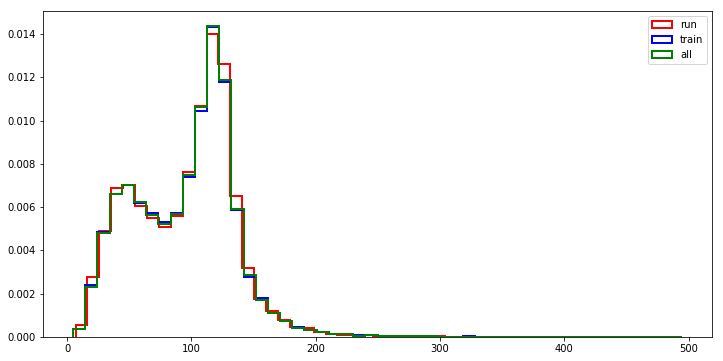

In [14]:
var = 18
plt.figure(figsize=(12,6))
hist_params = {'density': True, 'bins': 50, 'linewidth': 2}

plt.hist(X_run_check[X_run_check.target == 1]["h1_M"], color=["r"], histtype='step', label='run', **hist_params)
plt.hist(X_train_check[X_train_check.target ==1]["h1_M"], color=["b"], histtype='step', label='train', **hist_params)
plt.hist(allData[allData.target ==1]["h1_M"], color=["g"], histtype='step', label='all', **hist_params)
plt.legend(loc='best')

In [15]:
# Convert pandas dataframes into numpy arrays
X_test = X_test.values
X_train = X_train.values
X_run = X_run.values
evtWeightsTrain = evtWeightsTrain.values
evtWeightsVal = evtWeightsVal.values
evtWeightsRun = evtWeightsRun.values
yTypeTest = yTypeTest.values
yTypeTrain = yTypeTrain.values
yTypeRun = yTypeRun.values

In [16]:
X_test_check = X_test_check.values
X_train_check = X_train_check.values
X_run_check = X_run_check.values
allData_c = allData.copy()
allData_c = allData_c.values
sig_test_check = X_test_check[X_test_check[:, 20] == 1]
sig_train_check = X_train_check[X_train_check[:, 20] == 1]
sig_run_check = X_run_check[X_run_check[:, 20] == 1]
sig_all_check = allData_c[allData_c[:, 20] == 1]
print(sig_test_check)
print(sig_train_check)
print(sig_run_check)
print(sig_all_check)


[[ 19.73182604   0.           0.         ...   0.           2.05718988
    1.        ]
 [ 57.24132528   0.           0.         ...   1.           2.05718988
    1.        ]
 [ 32.01091698   0.           0.         ...   0.           2.05718988
    1.        ]
 ...
 [ 77.32810283   0.           0.         ...   0.           2.05718988
    1.        ]
 [280.94472574   0.           0.         ...   1.           2.05718988
    1.        ]
 [ 72.00170817   0.           0.         ...   1.           2.05718988
    1.        ]]
[[303.2583734    0.           0.         ...   0.           2.05718988
    1.        ]
 [190.95033916   0.           0.         ...   0.           2.05718988
    1.        ]
 [191.38464423   0.           0.         ...   1.           2.05718988
    1.        ]
 ...
 [183.78442907   0.           0.         ...   0.           2.05718988
    1.        ]
 [201.55820693   0.           0.         ...   1.           2.05718988
    1.        ]
 [160.65701961   0.           0.

In [18]:
# Scale input features to mean=0, stddev=1
classStd1 = StandardScaler().fit(X_train)
X_train = classStd1.transform(X_train)
X_test = classStd1.transform(X_test)
# scale run later
#X_run = classStd1.fit_transform(X_run)
joblib.dump(classStd1, "scaler_testingAppend_binary.sav")

['scaler_testingAppend_binary.sav']

In [19]:
X_train_check_scaled = classStd1.transform(X_train_check)
X_test_check_scaled = classStd1.transform(X_test_check)
X_run_check_scaled = classStd1.transform(X_run_check)
allData_c = classStd1.transform(allData_c)

sig_test_check = classStd1.transform(sig_test_check)
sig_train_check = classStd1.transform(sig_train_check)
sig_run_check = classStd1.transform(sig_run_check)
sig_all_check = classStd1.transform(sig_all_check)

ValueError: operands could not be broadcast together with shapes (716918,21) (19,) (716918,21) 

In [ ]:
np.unique(X_run_check_scaled[:,20],return_counts=True)

In [49]:
sig_scaled_test_check = X_test_check_scaled[X_test_check[:, 20] > 0]
sig_scaled_train_check = X_train_check_scaled[X_train_check[:, 20] >0]
sig_scaled_run_check = X_run_check_scaled[X_run_check[:, 20] > 0]
sig_scaled_all_check = allData_c[allData_c[:, 20] > 0]
print(np.shape(sig_scaled_all_check))
print(np.shape(sig_all_check))

(48610, 21)
(48610, 21)


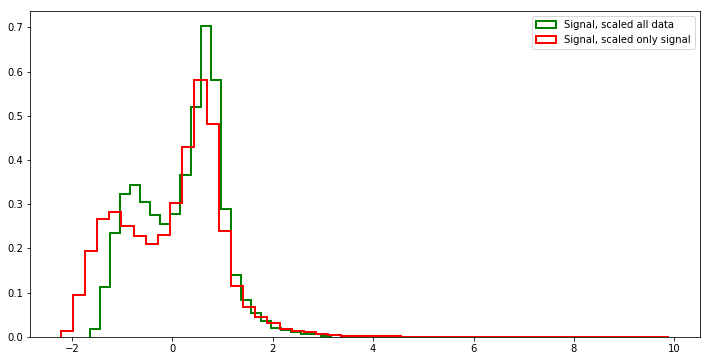

In [60]:
var = 3
plt.figure(figsize=(12,6))
plt.hist(sig_scaled_all_check[:,var], color=["g"], histtype='step', label='Signal, scaled all data', **hist_params)
plt.hist(sig_all_check[:,var], color=["r"], histtype='step', label='Signal, scaled only signal', **hist_params)
plt.legend(loc='best')

In [210]:
np.shape(X_test_check)
print(X_test_check[:,20])

[0. 0. 0. ... 0. 0. 0.]


In [193]:
#check that sig and bkg are in array
np.unique(X_run_check[:,20],return_counts=True)

(array([0., 1.]), array([577976,  19456]))

In [16]:
print(np.unique(yTypeTrain,return_counts=True))
print(np.unique(yTypeTest,return_counts=True))
print(np.unique(yTypeRun,return_counts=True))

(array([0, 1]), array([693653,  23265]))
(array([0, 1]), array([173354,   5876]))
(array([0, 1]), array([577963,  19469]))


In [219]:
allData_c = allData.copy()
allData_c = allData_c.values
sig_test_check = X_test_check[X_test_check[:, 20] == 1]
sig_train_check = X_train_check[X_train_check[:, 20] == 1]
sig_run_check = X_run_check[X_run_check[:, 20] == 1]
sig_all_check = allData_c[allData_c[:, 20] == 1]
print(sig_test_check)
print(sig_train_check)
print(sig_run_check)
print(sig_all_check)


[[ 96.1986328    0.           0.         ...   0.           2.05718988
    1.        ]
 [ 14.13265549   0.           0.         ...   0.           2.05718988
    1.        ]
 [218.65624947   0.           0.         ...   0.           2.05718988
    1.        ]
 ...
 [214.55886977   0.           0.         ...   0.           2.05718988
    1.        ]
 [122.92881514   0.           0.         ...   1.           2.05718988
    1.        ]
 [112.56722436   0.           0.         ...   1.           2.05718988
    1.        ]]
[[ 89.19975488   0.           0.         ...   0.           2.05718988
    1.        ]
 [ 86.63487035   0.           0.         ...   0.           2.05718988
    1.        ]
 [216.53259959   0.           0.         ...   0.           2.05718988
    1.        ]
 ...
 [148.26342555   0.           0.         ...   0.           2.05718988
    1.        ]
 [383.23189485   0.           0.         ...   0.           2.05718988
    1.        ]
 [ 66.59147316   0.           0.

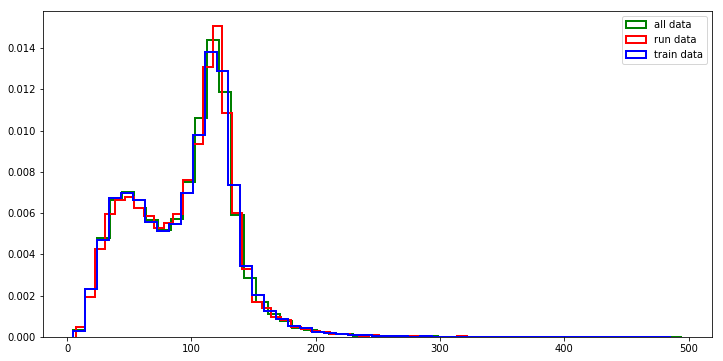

In [222]:
var = 3
plt.figure(figsize=(12,6))
plt.hist(sig_all_check[:,var], color=["g"], histtype='step', label='all data', **hist_params)
plt.hist(sig_run_check[:,var], color=["r"], histtype='step', label='run data', **hist_params)
plt.hist(sig_train_check[:,var], color=["b"], histtype='step', label='train data', **hist_params)
plt.legend(loc='best')

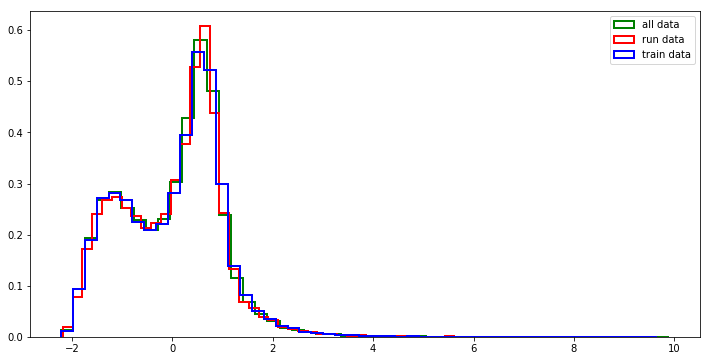

In [223]:
sig_test_check = classStd1.fit_transform(sig_test_check)
sig_train_check = classStd1.fit_transform(sig_train_check)
sig_run_check = classStd1.fit_transform(sig_run_check)
sig_all_check = classStd1.fit_transform(sig_all_check)
plt.figure(figsize=(12,6))
plt.hist(sig_all_check[:,var], color=["g"], histtype='step', label='all data', **hist_params)
plt.hist(sig_run_check[:,var], color=["r"], histtype='step', label='run data', **hist_params)
plt.hist(sig_train_check[:,var], color=["b"], histtype='step', label='train data', **hist_params)
plt.legend(loc='best')

In [18]:
len(signalData)

48610

In [19]:
len(allData)

1493580

In [20]:
# Set all event weights to 1 by default
signalData.loc[:, 'mc_sf'] = 1.
# Apply manual event weighting: numbers that give "reasonable behavior"
signalData.loc[signalData.target == 0, 'mc_sf'] = signal_weight[analysis] # signal

sig_only_target = signalData.pop("target")
sig_only_mc_sf = signalData.pop("mc_sf")

sig_only_mc_sf = sig_only_mc_sf.values
sig_only_target = sig_only_target.values

allSigData = signalData.values
og_mean = statistics.mean(allSigData[:,0])
print(og_mean)

161.2232244582874


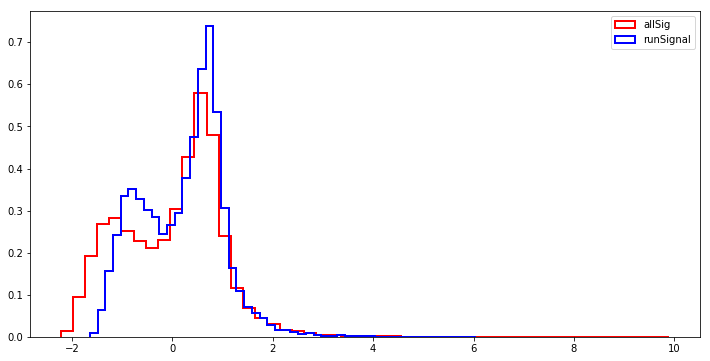

In [195]:
allSigData_scaled = classStd1.fit_transform(allSigData)
scaled_mean = statistics.mean(allSigData_scaled[:,0])
#print(allSigData)
#print(allSigData_scaled)
var = 3
plt.figure(figsize=(12,6))
plt.hist(allSigData_scaled[:,var], color=["r"], histtype='step', label='allSig', **hist_params)
plt.hist(isSignal[:,var], color=["b"], histtype='step', label='runSignal', **hist_params)
plt.legend(loc='best')

In [138]:
print(isSignal[:,var])
print(allSigData_scaled[:,var])

[ 1.30959713 -0.76359361  1.30959713 ...  1.30959713  1.30959713
 -0.76359361]
[ 1.05330091 -0.94939631  1.05330091 ... -0.94939631 -0.94939631
  1.05330091]


### np.shape(X_run_clone[:,0])

[[332.1892441    0.           0.         ...   0.           0.
    1.        ]
 [136.7990019    0.           0.         ...   0.           1.
    0.        ]
 [366.83894541   0.           0.         ...   1.           1.
    0.        ]
 ...
 [464.59895456   0.           0.         ...   0.           1.
    0.        ]
 [ 12.33005872   0.           0.         ...   0.           1.
    0.        ]
 [108.31320696   0.           0.         ...   1.           1.
    0.        ]]


(array([1.26484290e-03, 3.07430426e-03, 3.74035954e-03, 3.80868274e-03,
        3.63202120e-03, 3.22232188e-03, 2.60914032e-03, 1.94932241e-03,
        1.38340093e-03, 9.84353122e-04, 7.26989594e-04, 5.59444210e-04,
        4.39638704e-04, 3.47325612e-04, 2.85911496e-04, 2.00603451e-04,
        1.32472167e-04, 8.93863261e-05, 6.12221965e-05, 3.60328132e-05,
        2.37979698e-05, 1.72727200e-05, 1.39141356e-05, 1.14671669e-05,
        9.26009712e-06, 8.06060268e-06, 7.48484534e-06, 6.14141156e-06,
        5.90151267e-06, 4.46211934e-06, 3.11868556e-06, 1.91919111e-06,
        9.59595557e-07, 7.67676445e-07, 7.67676445e-07, 5.75757334e-07,
        2.87878667e-07, 2.39898889e-07, 1.43939333e-07, 4.79797778e-08,
        0.00000000e+00, 4.79797778e-08, 4.79797778e-08, 0.00000000e+00,
        9.59595557e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.79797778e-08, 4.79797778e-08]),
 array([5.00662959e-02, 3.49362358e+01, 6.98224053e+01, 1.04708575e+02,
        1.39594744e+02

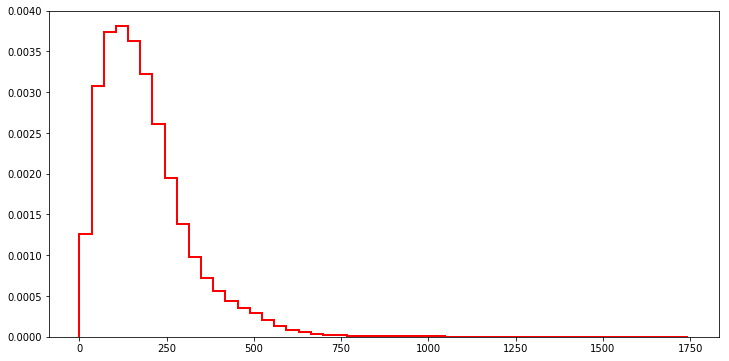

In [97]:
print(X_run_clone)
plt.figure(figsize=(12,6))
plt.hist(X_run_clone[:,0], color=["r"], histtype='step', label='Signal', **hist_params)

In [20]:
# Construct the NN architecture
model = Sequential()
model.add(Dense(100, activation="relu", input_dim= nFeatures))#input_dim should be as long as the branchList given to the NN
#model.add(Dropout(dropoutFraction))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, activation="sigmoid")) # output nodes

model.compile(
        loss='binary_crossentropy',  # we train 10-way classification
        #optimizer=keras.optimizers.adamax(lr=init_lr[analysis]),  # for SGD
        #optimizer=keras.optimizers.adamax(lr=50000),  # for SGD
        optimizer='sgd',
        metrics=['acc']  # report accuracy during training
        )

In [21]:
# Train the NN
history = model.fit(X_train, yTypeTrain, validation_data=(X_test, yTypeTest), epochs=numEpochs, batch_size=batchSize, sample_weight=evtWeightsTrain,shuffle=True)
# no need to save model for now 
model.save("testingAppend_binary.h5")

Train on 716918 samples, validate on 179230 samples
Epoch 1/5
716918/716918 [==============================] - 18s 26us/step - loss: 0.0842 - acc: 0.6450 - val_loss: 0.6068 - val_acc: 0.6909
Epoch 2/5
716918/716918 [==============================] - 18s 25us/step - loss: 0.0799 - acc: 0.7005 - val_loss: 0.5820 - val_acc: 0.7046
Epoch 3/5
716918/716918 [==============================] - 18s 25us/step - loss: 0.0787 - acc: 0.7004 - val_loss: 0.5834 - val_acc: 0.6988
Epoch 4/5
716918/716918 [==============================] - 18s 25us/step - loss: 0.0779 - acc: 0.7008 - val_loss: 0.5668 - val_acc: 0.7099
Epoch 5/5
716918/716918 [==============================] - 18s 25us/step - loss: 0.0772 - acc: 0.7025 - val_loss: 0.5859 - val_acc: 0.6917


2019-07-08 11:55:13.943499: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX


In [22]:
# Run training sample back through the NN
probTrain = model.predict(X_train)
probTest = model.predict(X_test)

In [23]:
print(np.unique(probTrain,return_counts=True))
len(probTrain)

(array([6.9371644e-08, 1.0221024e-06, 1.1932505e-06, ..., 9.7140580e-01,
       9.7282332e-01, 9.7762930e-01], dtype=float32), array([1, 1, 1, ..., 1, 1, 1]))


716918

In [24]:
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred)
#print(cm)
probTrain[:,0]

array([0.84829813, 0.29075667, 0.66649294, ..., 0.6493206 , 0.2973578 ,
       0.21009514], dtype=float32)

In [25]:
# Construct discriminant
#scores_train = np.log(probTrain[:,0]/(probTrain[:,1]+probTrain[:,2]))
#scores_test = np.log(probTest[:,0]/(probTest[:,1]+probTest[:,2]))

# Format data for convenience
trainData = pandas.DataFrame(X_train)
trainData['score'] = pandas.Series(probTrain[:,0], index=trainData.index)
trainData['weight'] = pandas.Series(evtWeightsTrain, index=trainData.index)
trainData['process'] = pandas.Series(yTypeTrain, index=trainData.index)


In [26]:
testData = pandas.DataFrame(X_test)
testData['score'] = pandas.Series(probTest[:,0], index=testData.index)
testData['weight'] = pandas.Series(evtWeightsVal, index=testData.index)
testData['process'] = pandas.Series(yTypeTest, index=testData.index)

Text(0,0.5,'1/N dN/d(NN Score)')

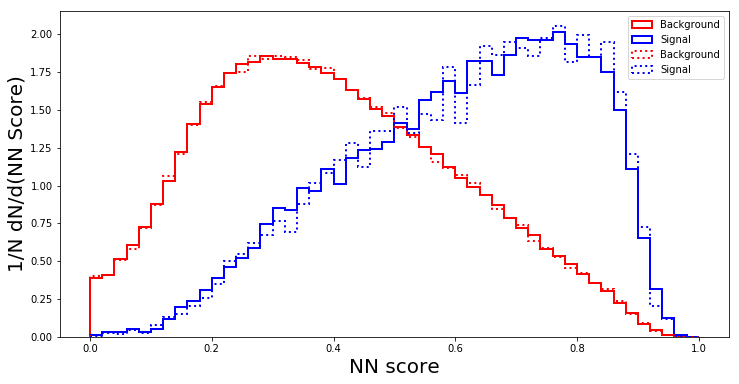

In [27]:
# Plot distributions of signal score on validation data
hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(trainData[trainData.process == 0]['score'], color=["r"], weights=trainData[trainData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Background', **hist_params)
plt.hist(trainData[trainData.process == 1]['score'], color=["b"], weights=trainData[trainData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(testData[testData.process == 0]['score'], color=["r"], linestyle = "dotted", weights=testData[testData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Background', **hist_params)
plt.hist(testData[testData.process == 1]['score'], color=["b"], linestyle = "dotted", weights=testData[testData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.legend(loc='best')
plt.xlabel("NN score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)
#plt.yscale('log')


In [28]:
signalAppendData = pandas.DataFrame(datAppend_sig)


In [29]:
print(np.unique(yTypeRun,return_counts=True))

(array([0, 1]), array([577933,  19499]))


In [30]:
##append_mc_sf = signalAppendData.pop("mc_sf")
#append_mc_sf = X_run.pop("mc_sf")
#append_mc_sf = append_mc_sf.values
## Convert pandas dataframes into numpy arrays
## signalAppendData = signalAppendData.values
#X_run = X_run.values

In [31]:
X_run_clone = X_run
appendData_clone = pandas.DataFrame(X_run_clone)

X_run = classStd1.transform(X_run)


In [32]:
# Run training sample back through the NN
probAppend = model.predict(X_run)

In [33]:
# Format data for convenience
appendData = pandas.DataFrame(X_run)
appendData['score'] = pandas.Series(probAppend[:,0], index=appendData.index)
appendData['weight'] = pandas.Series(evtWeightsRun, index=appendData.index)
appendData['process'] = pandas.Series(yTypeRun, index=appendData.index)


In [34]:
probAppend[:,0]
print(np.unique(yTypeRun,return_counts=True))
print(appendData[appendData["process"]==1])

(array([0, 1]), array([577933,  19499]))
               0         1       2         3         4         5         6  \
0      -0.468722 -0.079556 -0.0698  0.837375 -0.083065 -0.423006  0.435801   
10     -1.004664 -0.079556 -0.0698 -0.312927 -0.827956  1.338209 -1.456115   
85      0.049898 -0.079556 -0.0698  0.731595 -0.288225 -1.187272  0.299506   
112    -0.494964 -0.079556 -0.0698  0.922055 -0.474701  1.216668  0.285517   
119    -0.002707 -0.079556 -0.0698 -0.154285 -0.306803 -0.021776 -1.732512   
146    -0.667866 -0.079556 -0.0698  0.575098 -0.113824  1.959130 -1.571635   
166     0.456205 -0.079556 -0.0698  0.069738 -0.300608  1.344799 -1.578877   
194    -0.589144 -0.079556 -0.0698  0.674597 -0.767308 -1.258563  0.796878   
225    -0.716603 -0.079556 -0.0698  3.664962  1.465464  0.439212  0.176800   
227     0.008754 -0.079556 -0.0698  4.027929  0.586462 -1.258953  0.801504   
241     0.280139 -0.079556 -0.0698  1.030801 -0.203300 -0.626265  1.223461   
274     0.063807 -0.079

Text(0,0.5,'1/N dN/d(NN Score)')

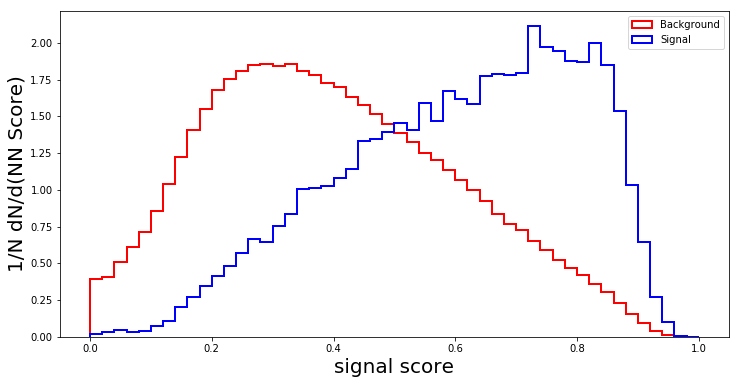

In [35]:
# Plot distributions of signal score on validation data
hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(appendData[appendData.process == 0]['score'], color=["r"], weights=appendData[appendData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Background', **hist_params)
plt.hist(appendData[appendData.process == 1]['score'], color=["b"], weights=appendData[appendData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)
#plt.yscale('log')


Text(0,0.5,'leading higgs candidate mass')

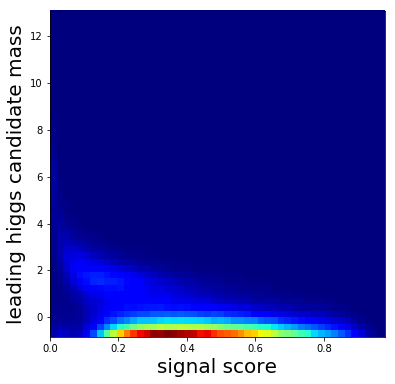

In [36]:
plt.figure(figsize=(6,6))
plt.hist2d(appendData[appendData.process == 0]['score'],appendData[appendData.process == 0][4],bins=(50,50),cmap=plt.cm.jet)
plt.xlabel("signal score",fontsize=20)
plt.ylabel("leading higgs candidate mass",fontsize=20)

Text(0,0.5,'leading higgs candidate mass')

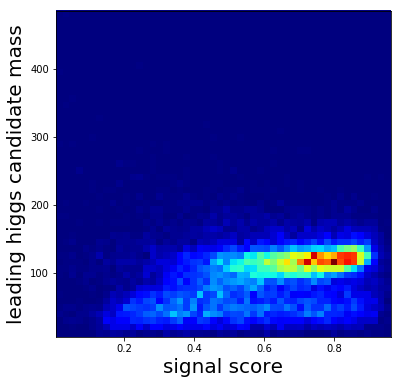

In [37]:
appendData_clone['process'] = pandas.Series(yTypeRun, index=appendData.index)
plt.figure(figsize=(6,6))
plt.hist2d(appendData[appendData.process == 1]['score'],appendData_clone[appendData_clone.process == 1][3],bins=(50,50),cmap=plt.cm.jet)
plt.xlabel("signal score",fontsize=20)
plt.ylabel("leading higgs candidate mass",fontsize=20)

In [38]:
plt.savefig("nn_vs_h1M_signal.png")

<Figure size 432x288 with 0 Axes>

In [39]:
appendData_clone.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,process
0,128.499986,0.0,0.0,126.077698,334.018890,-0.422253,0.790535,0.838587,83.958820,226.306127,-0.366827,-2.606621,0.734195,17.266542,2.834165,0.0,1.0,0.0,0.0,1
1,308.774847,0.0,0.0,47.823994,370.286377,1.767087,2.677764,0.263647,107.239077,149.580689,0.430266,0.489405,1.280279,47.994633,-0.389635,0.0,0.0,0.0,1.0,0
2,105.737379,0.0,0.0,79.541115,258.018616,0.482340,-0.718144,0.265033,100.120872,205.940972,-0.541282,2.825358,1.071476,4.506536,-2.805694,0.0,1.0,0.0,0.0,0
3,250.837366,0.0,0.0,189.052780,385.501343,-0.124055,-2.029981,1.009126,268.799030,212.580023,-0.943831,0.465698,2.492892,250.780884,1.171305,0.0,0.0,0.0,1.0,0
4,294.100349,0.0,0.0,54.741177,329.945862,-0.961495,2.951643,1.004202,144.238429,77.099836,2.710758,0.790672,2.191273,62.969444,-0.437883,0.0,0.0,0.0,1.0,0


Text(0,0.5,'1/N dN/d(NN Score)')

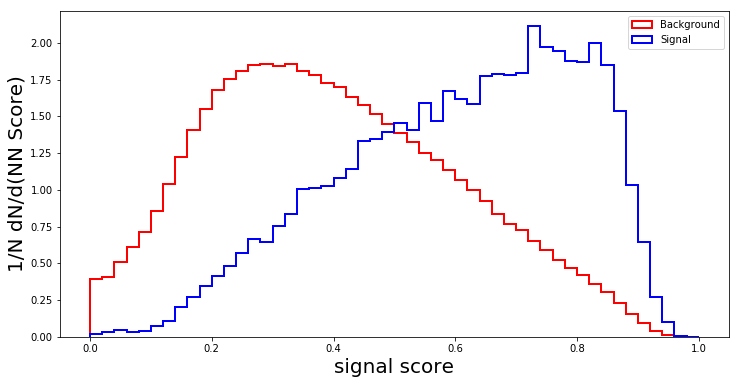

In [40]:
loaded_model = keras.models.load_model("./testingAppend_binary.h5")
pred_loaded = loaded_model.predict(X_run)

loaded_model_Data = pandas.DataFrame(X_run)
loaded_model_Data['score'] = pandas.Series(pred_loaded[:,0], index=loaded_model_Data.index)
loaded_model_Data['weight'] = pandas.Series(evtWeightsRun, index=loaded_model_Data.index)
loaded_model_Data['process'] = pandas.Series(yTypeRun, index=loaded_model_Data.index)

hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(loaded_model_Data[loaded_model_Data.process == 0]['score'], color=["r"], weights=loaded_model_Data[loaded_model_Data.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Background', **hist_params)
plt.hist(loaded_model_Data[loaded_model_Data.process == 1]['score'], color=["b"], weights=loaded_model_Data[loaded_model_Data.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

In [41]:
isSignal = loaded_model_Data[loaded_model_Data["process"] == 1]
isSignal.pop("process")
isSignal.pop("score")
isSignal.pop("weight")
print(isSignal)


              0         1       2         3         4         5         6   \
0      -0.468722 -0.079556 -0.0698  0.837375 -0.083065 -0.423006  0.435801   
10     -1.004664 -0.079556 -0.0698 -0.312927 -0.827956  1.338209 -1.456115   
85      0.049898 -0.079556 -0.0698  0.731595 -0.288225 -1.187272  0.299506   
112    -0.494964 -0.079556 -0.0698  0.922055 -0.474701  1.216668  0.285517   
119    -0.002707 -0.079556 -0.0698 -0.154285 -0.306803 -0.021776 -1.732512   
146    -0.667866 -0.079556 -0.0698  0.575098 -0.113824  1.959130 -1.571635   
166     0.456205 -0.079556 -0.0698  0.069738 -0.300608  1.344799 -1.578877   
194    -0.589144 -0.079556 -0.0698  0.674597 -0.767308 -1.258563  0.796878   
225    -0.716603 -0.079556 -0.0698  3.664962  1.465464  0.439212  0.176800   
227     0.008754 -0.079556 -0.0698  4.027929  0.586462 -1.258953  0.801504   
241     0.280139 -0.079556 -0.0698  1.030801 -0.203300 -0.626265  1.223461   
274     0.063807 -0.079556 -0.0698  1.041094 -0.458835 -0.039133

In [42]:

print(sig_only_Data)

NameError: name 'sig_only_Data' is not defined

(array([0.02051387, 0.03589928, 0.04359198, 0.03589928, 0.04102775,
        0.07436279, 0.11026206, 0.20001026, 0.26924458, 0.3461716 ,
        0.41540592, 0.482076  , 0.56925996, 0.66670086, 0.64618698,
        0.75644905, 0.83337607, 1.00261552, 1.01287245, 1.02569363,
        1.07954254, 1.14108416, 1.33083748, 1.34365865, 1.3923791 ,
        1.45392071, 1.4077645 , 1.58726089, 1.46674188, 1.67444484,
        1.61546746, 1.58213242, 1.77188574, 1.78470691, 1.78214267,
        1.79496384, 2.11292887, 1.97446023, 1.94112519, 1.8744551 ,
        1.86932663, 2.00010257, 1.84624853, 1.53341197, 1.03338633,
        0.64618698, 0.26924458, 0.09744089, 0.00512847, 0.        ]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

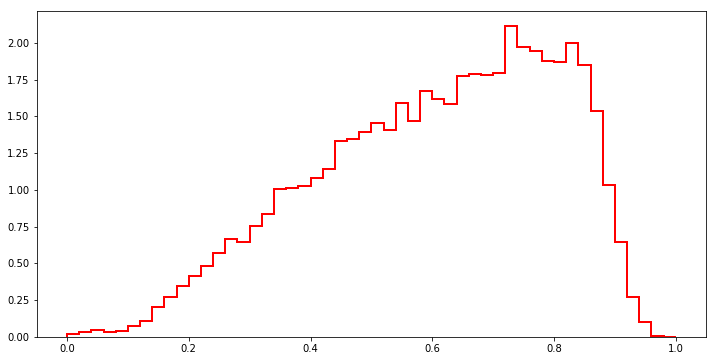

In [45]:
#isSignal = isSignal.values
pred_filtered = model.predict(isSignal)
plt.figure(figsize=(12,6))
plt.hist(pred_filtered, color=["r"], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)

In [46]:
loaded_model.compile(
        loss='binary_crossentropy',  # we train 10-way classification
        #optimizer=keras.optimizers.adamax(lr=init_lr[analysis]),  # for SGD
        #optimizer=keras.optimizers.adamax(lr=50000),  # for SGD
        optimizer='sgd',
        metrics=['acc']  # report accuracy during training
        )
pred_sig_only = loaded_model.predict(allSigData_scaled)
hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
plt.figure(figsize=(12,6))
plt.hist(pred_sig_only, color=["r"], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)

NameError: name 'allSigData_scaled' is not defined

In [47]:
pred_sig_only_mem = model.predict(allSigData_scaled)
plt.figure(figsize=(12,6))
plt.hist(pred_sig_only_mem, color=["r"], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)

NameError: name 'allSigData_scaled' is not defined

In [48]:
sig_only_Data = pandas.DataFrame(allSigData_scaled)
sig_only_Data['score'] = pandas.Series(pred_sig_only[:,0], index=sig_only_Data.index)

hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(sig_only_Data['score'], color=["r"], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

NameError: name 'allSigData_scaled' is not defined

In [49]:
sig_only_Data['weight'] = pandas.Series(sig_only_mc_sf, index=sig_only_Data.index)
sig_only_Data['process'] = pandas.Series(sig_only_target, index=sig_only_Data.index)

hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(sig_only_Data[sig_only_Data.process == 1]['score'], color=["b"], weights=sig_only_Data[sig_only_Data.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

NameError: name 'sig_only_mc_sf' is not defined